# Process and Compare Ice Edges
Go from an image of either ice/no ice or predicted probabilities of ice/no ice to evaluating ice-edges with Melsom metrics.

In [1]:
import tensorflow as tf
import numba
import numpy as np

import matplotlib.pyplot as plt

How UNet constructs a batch of images if it's relevant to understand:
```py
def load_n_day_chunk(year: int, day: int, n=4) -> np.array:
    """
    Return np.array with shape (height, width, channels).

    Does NOT wrap years or account for missing days.
    Starts n_day chunk at specified day, year.

    Returns:
        np.array: shape (sie_y_shape, sie_x_shape, n_day)
    """
    sie_chunk = []
    for new_day in range(day, day + n):
        sie = trinarize_data(load_sie_data(year, new_day))
        sie_chunk.append(sie)

    assert len(sie_chunk) == n
    
    # Use np.stack to stack the individual 2D arrays along a new third axis, resulting in (height, width, channels)
    # latest image is [..., -1], first image is [..., 0]
    return np.stack(sie_chunk, axis=-1)
```

## Functions

From (batched) image with values between 0 and 1 representing probability or classification of ice/no ice:

In [2]:
def image_batch_to_binary_edge_image(image_batch: np.array) -> np.array:
    """
    Perform Sobel edge detection on an (optionally batched) image
    Image has dimension (batch_size, window_size, window_size).
    """
    binary_ice_no_ice = np.round(image_batch)
    assert np.allclose(np.unique(binary_ice_no_ice), np.array([0, 1]))

    # Sobel expects input to have dimension (batch, window, window, 1)
    batch_tensor = tf.expand_dims(tf.convert_to_tensor(binary_ice_no_ice), axis=-1)

    sobel_edges = tf.image.sobel_edges(batch_tensor)
    sobel_x = sobel_edges[..., 0]
    sobel_y = sobel_edges[..., 1]

    # Apply absolute value, threshold, and sum the results of x and y edges
    edges_x = tf.cast(tf.square(sobel_x) >= 1, tf.float32)
    edges_y = tf.cast(tf.square(sobel_y) >= 1, tf.float32)
    edge_magnitudes = edges_x + edges_y
    return edge_magnitudes

In [3]:
def process_binary_edge_image_into_coordinates(activated: np.array) -> np.array:
    """
    Takes a numpy array of edge detected pixels (not SIE).
    Cannot take in a tensorflow tensor, input array must be between 0 and 1.
    Input array is the result of running edge-detection on Ice/No Ice array.

    Parameters:
        activated: Numpy array with >= 0.5 indicating sea-ice edge.

    Returns:
        numpy array of integer indices in input array corresponding to edge pixels. Of shape (N Edges, 2)

    """
    edges = np.where(np.round(activated) >= 1)
    x, y = edges[0], edges[1]
    edge_coordinates = np.stack((x, y), axis=-1)

    return edge_coordinates

In [4]:
@numba.jit(nopython=True)
def average_and_rms_ice_edge_displacement(observed_edges, model_edges):
    """
    Calculate both the average (D_AVG_IE) and RMS ice edge displacement (D_RMS_IE) between observed and model ice edges.
    Credit: Validation metrics for ice edge position forecasts, Melsom et al., 2019.

    Parameters:
    - observed_edges: numpy array of shape (N, 2), where N is the number of observed ice edge points,
      and each point is represented by its (x, y) coordinates.
    - model_edges: numpy array of shape (M, 2), where M is the number of model ice edge points,
      and each point is represented by its (x, y) coordinates.

    Returns:
    - D_AVG_IE: The average displacement between the observed and model ice edges.
    - D_RMS_IE: The root mean square displacement between the observed and model ice edges.
    """

    # Initialize lists to store minimum distances for each point
    observed_to_model_distances = []
    model_to_observed_distances = []

    # Calculate distances from each observed point to the nearest model point
    for obs_point in observed_edges:
        distances = np.sqrt(np.sum((model_edges - obs_point) ** 2, axis=1))
        observed_to_model_distances.append(np.min(distances))

    # Calculate distances from each model point to the nearest observed point
    for model_point in model_edges:
        distances = np.sqrt(np.sum((observed_edges - model_point) ** 2, axis=1))
        model_to_observed_distances.append(np.min(distances))

    # Calculate the average displacement
    avg_displacement = (
        sum(observed_to_model_distances) / len(observed_to_model_distances)
        + sum(model_to_observed_distances) / len(model_to_observed_distances)
    ) / 2

    # Calculate the root mean square displacement
    rms_displacement = np.sqrt(
        (
            sum([dist**2 for dist in observed_to_model_distances])
            + sum([dist**2 for dist in model_to_observed_distances])
        )
        / (len(observed_to_model_distances) + len(model_to_observed_distances))
    )

    return avg_displacement, rms_displacement

### Example usage
Create a fake batch chunk of data (batch size, window size, window size)

In [5]:
# Called batches, but could represent channels or n forecasts back
batches = 4

In [6]:
# Create a fake numpy array with simple shapes
fake_array = np.zeros((batches, 100, 100))

# Add a rectangle shifting slightly between frames
for i in range(batches):
    offset = 5 * i
    fake_array[i, 30 + offset : 70 + offset, 30 + offset : 70 + offset] = 1

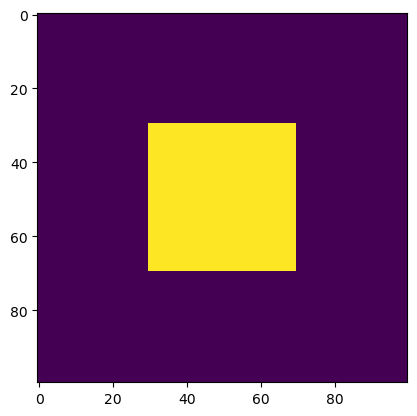

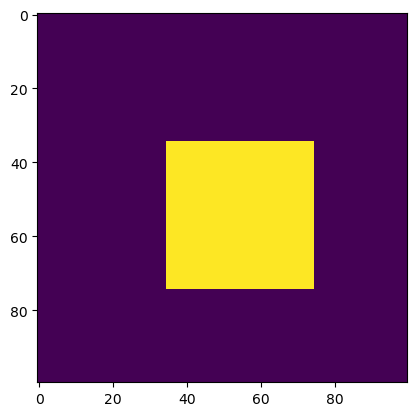

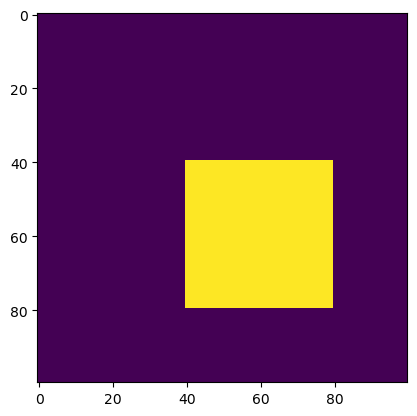

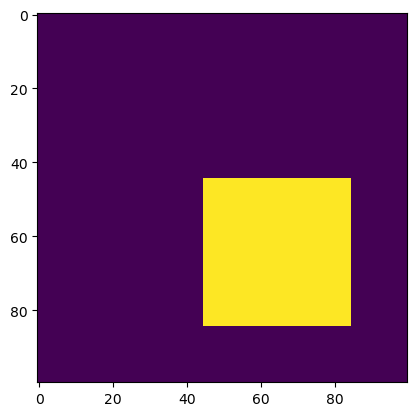

In [7]:
for i in range(batches):
    plt.imshow(fake_array[i])
    plt.show()

Get a binary edge/not edge 2D array from this

In [8]:
binary_edges = image_batch_to_binary_edge_image(fake_array)

2024-03-28 22:40:36.987989: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-03-28 22:40:36.988040: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: sven
2024-03-28 22:40:36.988046: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: sven
2024-03-28 22:40:36.988264: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 535.104.5
2024-03-28 22:40:36.988287: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 535.104.5
2024-03-28 22:40:36.988292: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 535.104.5
2024-03-28 22:40:36.989827: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operati

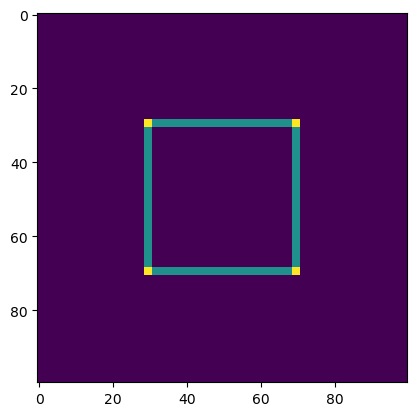

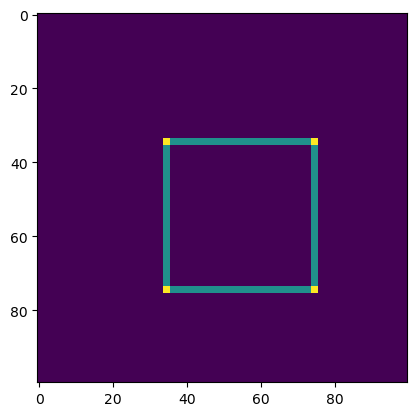

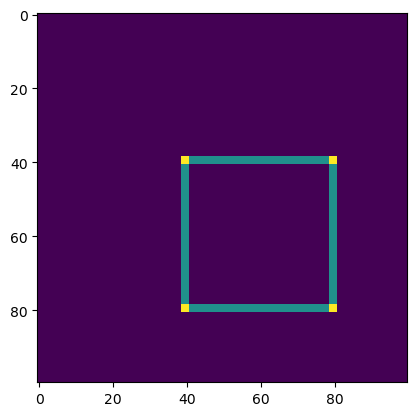

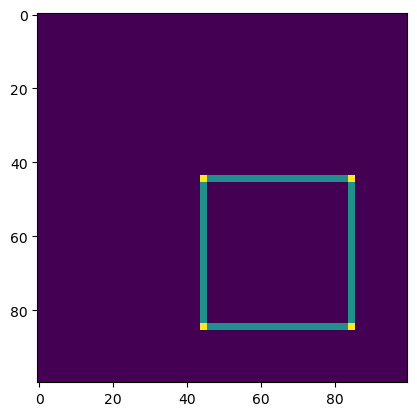

In [9]:
for i in range(binary_edges.shape[0]):
    plt.imshow(binary_edges[i])
    plt.show()

Next let's collect the edge coordinates from the binary edge/not edge image. 

We'll get (n_edge_pixels, 2) shaped array back. So the x, ycoordinates for edge pixel #2 are accessed like `edge_coordinates[batch_number, 1]`

In [10]:
edge_coordinates = {}
for i in range(batches):
    edge_coordinates[i] = process_binary_edge_image_into_coordinates(binary_edges[i])

Now we can evaluate our edges against each other.

For this example, we'll compare how the edges change between frames (instead of target image to model predictions).  
We know that the offset between the images was 5 pixels shifted down and to the right each time.

In [11]:
for i in range(1, batches):
    current_edges = edge_coordinates[i]
    previous_edges = edge_coordinates[i - 1]

    avg_displacement, rms_displacement = average_and_rms_ice_edge_displacement(
        current_edges, previous_edges
    )
    print(
        f"Edge displacements between frame {i-1} and {i}:\nAverage: {avg_displacement:0.3f}, RMS: {rms_displacement:0.3f}"
    )
    print()

Edge displacements between frame 0 and 1:
Average: 4.232, RMS: 4.376

Edge displacements between frame 1 and 2:
Average: 4.232, RMS: 4.376

Edge displacements between frame 2 and 3:
Average: 4.232, RMS: 4.376



The displacement remaining the same from one frame to another makes sense, because the offset is constant in between frames.

By the last frame however, the square has moved quite a bit. Play around with different batch sizes to see how much this changes relative to what you know the offset has been.

In [12]:
first_frame_coordinates = edge_coordinates[0]
last_frame_coordinates = edge_coordinates[batches - 1]

avg_displacement, rms_displacement = average_and_rms_ice_edge_displacement(
    first_frame_coordinates, last_frame_coordinates
)
print(
    f"Edge displacements between first and last frame:\nAverage: {avg_displacement:0.3f}, RMS: {rms_displacement:0.3f}"
)

Edge displacements between first and last frame:
Average: 12.083, RMS: 13.034
